## Create A Network Grid from Raster Grid

This notebook takes an .asc raster file representing a DEM and extracts a channel network from the topography using the [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html). It then uses this extracted channel network to create a NetworkModelGrid.

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

## Import a DEM
Setup this notebook to draw DEM data for the Hugo Site from the overland_flow tutorial folder.

In [2]:
tutorial_dir = os.path.dirname(os.getcwd())
raster_fn = os.path.join(tutorial_dir, 'overland_flow\\hugo_site.asc')

Import the Hugo Site as a RasterModelGrid and visualize:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


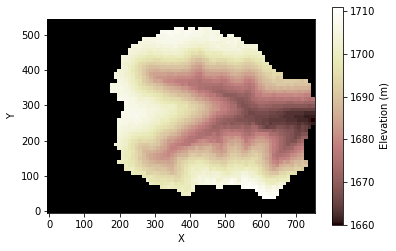

In [3]:
rmg, z = read_esri_ascii(raster_fn, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED


plt.figure()
imshow_grid_at_node(rmg, z, colorbar_label='Elevation (m)')
plt.show()

## Find flow accumulation:

Find where water will flow using the FlowAccumulator package:

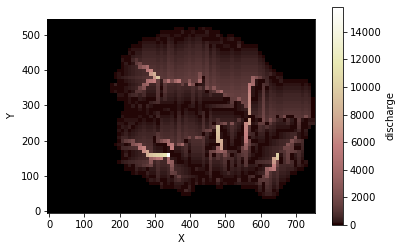

In [4]:
fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

Yuck, that doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

In [5]:
df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

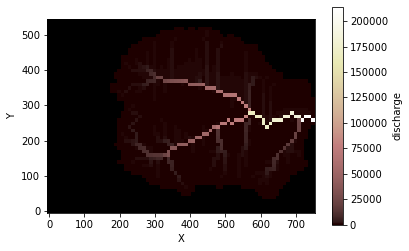

In [6]:
imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

That looks better! 

## Use the channel profiler to extract channels:
* note, toggle minimum channel threshhold to refine network!

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


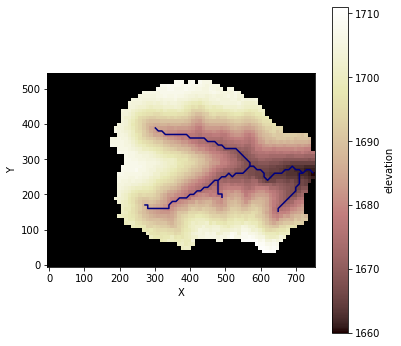

In [31]:
min_channel_thresh = 10000

profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=min_channel_thresh,
    main_channel_only=False,
    cmap='jet',
)
profiler.run_one_step()

plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')

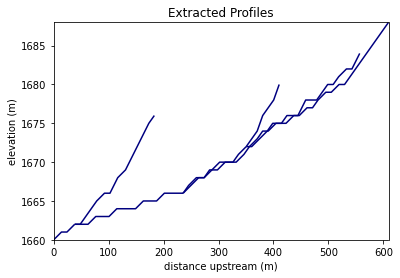

In [32]:
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

## Get network-grid nodes from channel.

Extract x,y network model grid (nmg) nodes from raster model grid (rmg) for each deliniated channel segment:
* note: need to remove duplicate values from channel junctures and create node_at_link list (more notes below)

In [33]:
d_node_spacing = 20 #units to space nodes, must be greater than grid resolution
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each channel segment
nodes_per_segment = [] #empty list to store number of nodes in each channel segment

#DEV ONLY: keep track of nodes per seg as explicit x and y locations (only toggle if using below)
# x_of_nodes = []
# y_of_nodes = []

#would be ideal to also create dictionary here that stores rmg cells along each link to tie rmg properties to nmg
#nmg_cells_on_link = {}

#obtain watershed key
ws_keys = [k for k in profiler.data_structure.keys()]

#sent message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('more than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    
    #access individual segment
    seg_i = profiler.data_structure[ws_keys[0]][seg_key] 
    
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    nodes_per_segment.append(n_possible_nodes)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #DEV ONLY: keep track of nodes per seg as explicit x and y locations
#     x_of_nodes.append(rmg.x_of_node[rmg_nodes_i])
#     y_of_nodes.append(rmg.y_of_node[rmg_nodes_i])
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

#get unique nodes
xy_df = pd.DataFrame({'x': x_of_nodes, 'y': y_of_nodes})
uniq_x_of_nodes = xy_df.drop_duplicates()['x'].values
uniq_y_of_nodes = xy_df.drop_duplicates()['y'].values

Plot nodes colored by segment:

Text(0.5, 1.0, 'Network Nodes colored by channel segment')

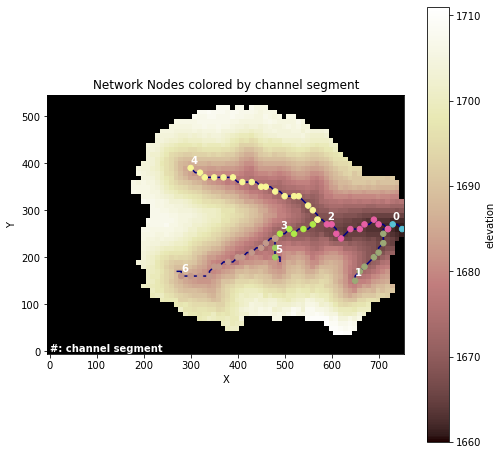

In [34]:
plt.figure(figsize = (8,8))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)

#hacky way to label channel segments with #s -------
node_id = 0 #dummy counter
idx_x = [] #store indexes to acces x,y location of last node on channel
#loop through channels, get node index
for node_len in nodes_per_segment:
    node_id+=node_len
    idx_x.append(node_id-1)
#plot numbers at last node for each channel seg
for i in range(n_channel_segs):
    plt.text(x_of_nodes[idx_x[i]],
             y_of_nodes[idx_x[i]]+10,
             '%d'%i,
             color='white',
             fontweight='bold')
plt.text(0,0,
         '#: channel segment',
         color='white',
         fontweight='bold')
#---------------------------------------------------
plt.title('Network Nodes colored by channel segment')

Plot unique network nodes:

Text(0.5, 1.0, 'Unique Network Nodes')

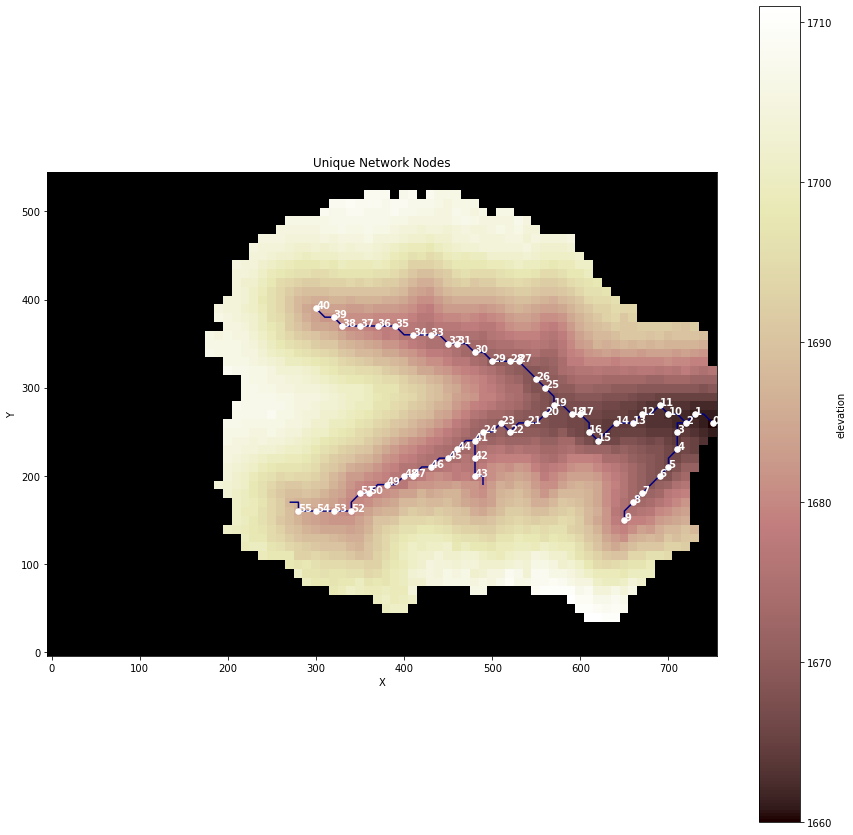

In [35]:
plt.figure(figsize = (15,15))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(uniq_x_of_nodes, uniq_y_of_nodes, s=30, c='white', zorder=2)
for i, (x,y) in enumerate(zip(uniq_x_of_nodes, uniq_y_of_nodes)):
    plt.text(x,y,
            '%d'%i,
             color='white',
            fontweight='bold')
#---------------------------------------------------
plt.title('Unique Network Nodes')

In [14]:
# for i, key in enumerate(nodes_at_link_per_seg.keys()):
#     print('segment %d nodes at link:'%i, nodes_at_link_per_seg[key])

#### Figure out how to get 'node at link' value for nmg: 

NEED TO:
* distinguish between outlet, channel head, or juncture at start and end of each segment
    * if outlet: 
        * create node at beginning
        * attach to upstream nodes
    * if juncture: 
        * create node at beginning (ONLY if a node hasn't already been created from another juncture) 
        * also tell the previous segment that it needs to be attached to this node idx (ONLY if it hasn't been attached from previous juncture)
    * if channel head: 
        * end with upstream node--don't attach to any other nodes
        * reduce idx of subsequent link numbers by 1 (since there is no link for this node)

### Target 'node_at_link' connections to include for each segment:
* KEY:
    * <span style="color:magenta">seg. head is first juncture link (or outlet): **()**</span> 
    * <span style="color:red">seg. head links to juncture (second juncture): ^()^</span> 
    * <span style="color:blue">seg. tail links to juncture: -()-</span>
    * <span style="color:green">seg tail: channel head _()_</span>
    * seg core nodes ()
    

* Seg 0: nodes to connect: (0-1, 2), [<span style="color:magenta">**(1,0)**</span>, <span style="color:blue">-(2,1)-</span>]  n=2, id_start = 0  
* Seg 1: nodes to connect: (2-7),  [<span style="color:magenta">**(3,2)**</span>, (4,3), (5,4), (6,5), <span style="color:green">_(7,6)_</span>] n=5, id_start = 2, 
* Seg 2: nodes to connect: (2, 8-14, 15), [<span style="color:red">^(8,2)^</span>, (9,8), (10,9), (11,10), (12,11), (13,12), (14,13), <span style="color:blue">-(15,14)-</span>] n=8, id_start = 7
* Seg 3: nodes to connect: (15-19, 32), [<span style="color:magenta">**(16,15)**</span>, (17,16), (18,17), (19,18), <span style="color:blue">-(32,19)-</span>]  n=5, id_start = 15
* Seg 4: nodes to connect: (15, 20-31), [<span style="color:red">^(20,15)^</span>, (21,20), (22,21), (23,22), (24,23), (25,24), (26,25), (27,26), (28,27), (29,28), (30,29),<span style="color:green">_(31,30)_</span>]  n=12, id_start=20
* Seg 5: nodes to connect: (32-34), [<span style="color:magenta">**(33,32)**</span>, <span style="color:green">_(34,33)_</span>] n=2, id_start=32
* Seg 6: nodes to connect: (32, 35-44), [<span style="color:red">^(35,32)^</span>, (36,35), (37,36), (38,37), (39,38), (40,39), (41,40), (42,41), (43,42), <span style="color:green">_(44,43)_</span>] n=10, id_start=34 (id_end=44)

In [36]:
#extract array of start and end nodes
# profile_start_and_end_nodes = np.array([[n1, n2] for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])
channel_start_nodes = np.array([n1 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])
channel_end_nodes = np.array([n2 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])

#create dictionary that holds segment endpoint type
#(this simply prints out a check to make sure things are being joined properly)
segment_endpoint_type = OrderedDict()

#define empty list to hold nodes per link
nodes_at_link_per_seg = OrderedDict()

#find idx of link per segment-----------------
# Need to correct for number of links per segment 
# channel segments ending in a channel head have (n-1 links per n nodes) 
# segments which connect to the network upstream have (n links per n nodes)
links_per_segment = np.array(nodes_per_segment.copy())
for i in range(n_channel_segs):
    #if channel end nodes do not exist in starting nodes, they must be channel heads
    if not np.any(channel_end_nodes[i] == channel_start_nodes):
        #subract a link if channel head
        links_per_segment[i] -= 1



#this id node start is helpful for connecting channel segments to others at junctures
id_node_start = np.cumsum(links_per_segment)
id_node_start = np.insert(id_node_start, 0, 0)
      



#iterate through channel segments to determine where to join
for i in range(n_channel_segs):
    #analyze segment 'i'
    #FIRST ENDPOINT:
    #check if first point equals start of any previous start points 
    #(means it's starting in an existing juncture, i.e. don't create a new node)
    if np.any(channel_start_nodes[:i] == channel_start_nodes[i]):
        #extract the first index of these
        first_juncture_idx = np.where(channel_start_nodes[:i] == channel_start_nodes[i])[0][0]
        segment_endpoint_type[i] = ['2nd juncture: refer to first node of seg %d'%(first_juncture_idx)]

    #create main links for segment
        #if we are looking at segment where the previous segment ends with a juncture and the current segment joins to a different juncture
        #channel must have jumped location (segments no longer in sequence) need to use id of 1 less since not starting new juncture
        #check this with two conditions 1 (does endpoint of channel exist as any start points?) & 2 (does start point exist at any previous start points)
        if i != 0:
            if np.any(channel_end_nodes[i-1] == channel_start_nodes) and np.any(channel_start_nodes[i] == channel_start_nodes[:i]):
                print('applying to seg: %d'%i, 'main cell range start: %d, main cell range end: %d'%(id_node_start[i], id_node_start[i+1]-2))
                nodes_at_link_per_seg[i] = [(n+1, n) for n in range(id_node_start[i], id_node_start[i+1]-2)]
                nodes_at_link_per_seg[i].insert(0, (id_node_start[i], id_node_start[first_juncture_idx]))                            
            else:
                nodes_at_link_per_seg[i] = [(n+1, n) for n in range(id_node_start[i]+1, id_node_start[i+1]-1)]
                #insert link reference at beginning according to previously created node
                nodes_at_link_per_seg[i].insert(0, (id_node_start[i]+1, id_node_start[first_juncture_idx]))

    #otherwise we need to create a node for the first link reference at this juncture
    else:
        segment_endpoint_type[i] = ['1st juncture: create node']
        #include the first index in creation of node references for links
        nodes_at_link_per_seg[i] = [(n+1, n) for n in range(id_node_start[i], id_node_start[i+1]-1)]


    #SECOND ENDPOINT: 
    #check if end of segment equals start of future segments
    if np.any(channel_start_nodes == channel_end_nodes[i]):
        first_juncture_idx = np.where(channel_start_nodes == channel_end_nodes[i])[0][0]
        segment_endpoint_type[i].append('juncture: join to first node of seg %d'%(first_juncture_idx))
        
        #join the first juncture index to the last node on this channel segment (so one less than the start of the next index)
        nodes_at_link_per_seg[i].append((id_node_start[first_juncture_idx], id_node_start[i+1]-1))

    #CHANNEL HEADS
    else:
        segment_endpoint_type[i].append('channel head: dont join')
        #correction to end headpoint for certain type of segment where previous one ended in juncture and current one joins to different juncture
        if i != 0:

            if (np.any(channel_end_nodes[i-1] == channel_start_nodes) and np.any(channel_start_nodes[i] == channel_start_nodes[:i])):
                print('applying end condition to seg %d: '%i)
                nodes_at_link_per_seg[i].append((id_node_start[i+1]-1,id_node_start[i+1]-2))
            
            else:
                nodes_at_link_per_seg[i].append((id_node_start[i+1],id_node_start[i+1]-1))


    print('segment %d:'%i, segment_endpoint_type[i])

segment 0: ['1st juncture: create node', 'juncture: join to first node of seg 1']
segment 1: ['1st juncture: create node', 'channel head: dont join']
segment 2: ['2nd juncture: refer to first node of seg 1', 'juncture: join to first node of seg 3']
segment 3: ['1st juncture: create node', 'juncture: join to first node of seg 5']
applying to seg: 4 main cell range start: 25, main cell range end: 39
applying end condition to seg 4: 
segment 4: ['2nd juncture: refer to first node of seg 3', 'channel head: dont join']
segment 5: ['1st juncture: create node', 'channel head: dont join']
segment 6: ['2nd juncture: refer to first node of seg 5', 'channel head: dont join']


In [37]:
for i, key in enumerate(nodes_at_link_per_seg.keys()):
    print('segment %d nodes at link:'%i, nodes_at_link_per_seg[key])

segment 0 nodes at link: [(1, 0), (2, 1)]
segment 1 nodes at link: [(3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8)]
segment 2 nodes at link: [(10, 2), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18)]
segment 3 nodes at link: [(20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (41, 24)]
segment 4 nodes at link: [(25, 19), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (38, 37), (39, 38), (40, 39)]
segment 5 nodes at link: [(42, 41), (43, 42)]
segment 6 nodes at link: [(44, 41), (45, 44), (46, 45), (47, 46), (48, 47), (49, 48), (50, 49), (51, 50), (52, 51), (53, 52), (54, 53), (55, 54)]


Still not quite assigning things properly for segment 4 (node index should start at 20) if there are two junctures in a row (tail is joined to different juncture and starting is joined to juncture) should start at 'node_id' not 'node_id+1'

Let's just see what this produces for a network model grid:

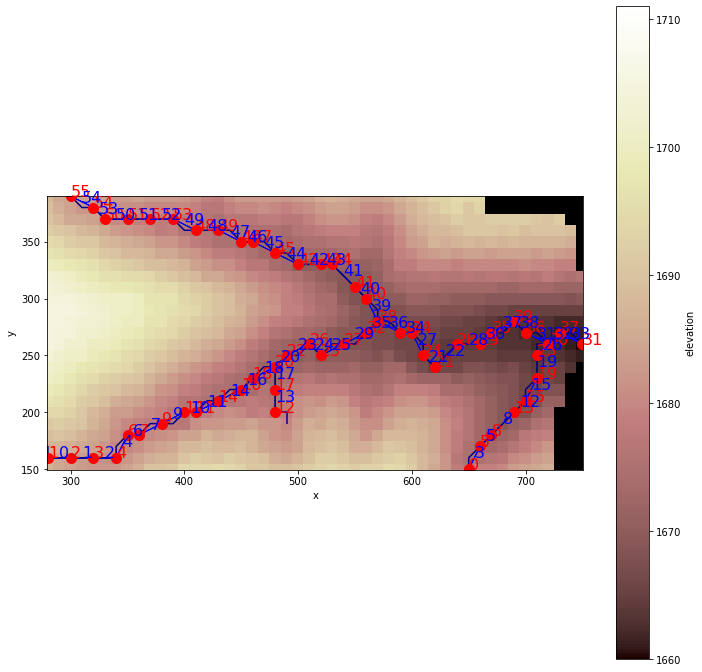

In [38]:
#unwrap nodes at link for 
nodes_at_link = []
for i in range(n_channel_segs):
    for item in nodes_at_link_per_seg[i]:
        nodes_at_link.append(item)
        
grid = NetworkModelGrid((uniq_y_of_nodes, uniq_x_of_nodes), nodes_at_link)

plt.figure(figsize = (12,12))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)
graph.plot_graph(grid, at="node,link")

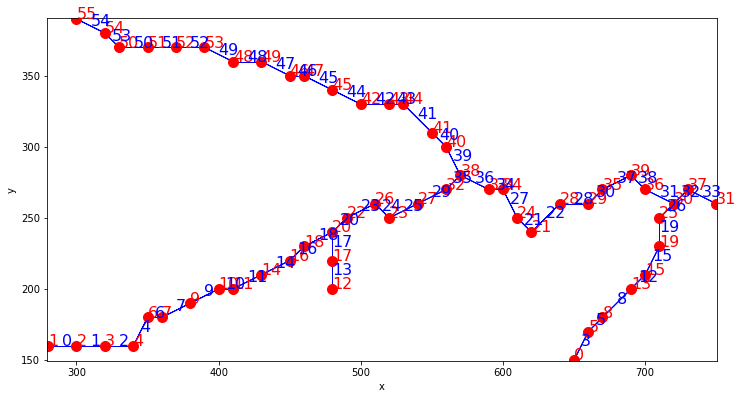

In [39]:
plt.figure(figsize = (12,12))
# profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)
graph.plot_graph(grid, at="node,link")